# Convert DCM to NII

In [3]:
!pip install nibabel

     |████████████████████████████████| 3.3 MB 5.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import pydicom
from PIL import Image
import cv2

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt

import nibabel as nib

plt.rcParams["figure.figsize"] = (20,20)

## See https://github.com/DonGovi/LIDC-IDRI-nodule-segmentation

In [2]:
from dataset.data_process import *
from drr_raysum import *

In [ ]:
aspects = calculate_ps(slices)

In [85]:
def resample(image, slices, new_spacing=[1,1,1]):
    '''
    3d resize
    '''
    # Determine current pixel spacing
    # SliceThickness를 쓰면 overlapping되게 찍은 경우 고려가 안되어서 ImagePositionPatient을 사용
    spacing = np.array(list(slices[0].PixelSpacing) + [np.abs(slices[1].ImagePositionPatient[-1]-slices[0].ImagePositionPatient[-1])], dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

def normalize_windowing(arr, WL, WW):
    return np.array(((arr - (WL-WW//2)) / ((WL+WW//2) - (WL-WW//2)))*255).astype(np.uint8)

def normalize255(arr):
    return np.array(((arr - np.min(arr)) / (np.max(arr) - np.min(arr)))*255).astype(np.uint8)

## File Location 상의 xml은 없는 것도 있어서 df_xml에서 가져오는 것으로

In [80]:
for f in df_cases["File Location"]:
    x_lst = glob(f"{f}/*xml")
    if len(x_lst) != 1:
        print(len(x_lst), f)

0 ./LIDC-IDRI/LIDC-IDRI-0069/01-01-2000-NA-NA-29787/3079.000000-NA-04249
0 ./LIDC-IDRI/LIDC-IDRI-0078/01-01-2000-NA-NA-68432/3165.000000-NA-53824
0 ./LIDC-IDRI/LIDC-IDRI-0079/01-01-2000-NA-NA-37490/3278.000000-NA-05159
0 ./LIDC-IDRI/LIDC-IDRI-0084/01-01-2000-NA-NA-27940/3211.000000-NA-79503
0 ./LIDC-IDRI/LIDC-IDRI-0098/01-01-2000-NA-NA-97960/3094.000000-ThoraxRoutine  3.0  B31s-45271
0 ./LIDC-IDRI/LIDC-IDRI-0101/01-01-2000-NA-NA-57752/3192.000000-ThoraxRoutine  3.0  B31s-17327
0 ./LIDC-IDRI/LIDC-IDRI-0103/01-01-2000-NA-NA-84710/5519.000000-ChestRoutine  3.0  B31f-39568
0 ./LIDC-IDRI/LIDC-IDRI-0106/01-01-2000-NA-NA-50782/3115.000000-NA-20243
0 ./LIDC-IDRI/LIDC-IDRI-0115/01-01-2000-NA-NA-06680/3236.000000-NA-37997
0 ./LIDC-IDRI/LIDC-IDRI-0117/01-01-2000-NA-NA-09107/3084.000000-NA-91206
0 ./LIDC-IDRI/LIDC-IDRI-0120/01-01-2000-NA-NA-71173/3221.000000-NA-29969
0 ./LIDC-IDRI/LIDC-IDRI-0119/01-01-2000-NA-NA-54647/5608.000000-ThorRoutine  2.0  B70f-82299
0 ./LIDC-IDRI/LIDC-IDRI-0127/01-01-2000

## WL, WW 정해서 8bit로 3D CT Slices와 Nodule 정보 convert

In [86]:
df_cases = pd.read_csv("../df_cases.csv")
df_xml = pd.read_csv("../xml_cases.csv")
dir_lst = sorted(list(df_cases["File Location"]))
WL = 0
WW = 2000

In [16]:
dir_lst[914]

'./LIDC-IDRI/LIDC-IDRI-0909/01-01-2000-NA-NA-88603/30707.000000-NA-80403'

In [5]:
df_xml[df_xml["CT Location"] == d]

NameError: name 'd' is not defined

In [6]:
tmp_dr.path.values[0]

NameError: name 'tmp_dr' is not defined

In [90]:
cid = 0

for d in tqdm(dir_lst):
#     cid+=1
#     if cid < 136:
#         continue
    
    dpath = sorted(glob(f"{d}/*dcm"))
    tmp_dr = df_xml[df_xml["CT Location"] == d]
    
    try:
        nodules = parseXML(tmp_dr.path.values[0])
        transed_nodule_list, image_array, deps, cols, rows = coord_trans(nodules, d)
        transed_nodule_list = duplicate_nodules(transed_nodule_list)
        filled_nodule_list = fill_hole(transed_nodule_list, deps, cols, rows)
        union_nodule_list = calc_union_freq(filled_nodule_list)
    except UnboundLocalError:
        print(d)
        continue
    
    slices = []
    for fname in dpath:
        ds = pydicom.dcmread(fname, force=True)
        slices.append(ds)

    slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1], reverse=True)
    
    img3d = slices2img3d(slices, WL, WW)
    img3d = normalize_windowing(img3d, WL, WW)
    img_shape = img3d.shape
    
    mask_tmp = np.zeros(img_shape)
    for u in union_nodule_list:
        mask = mask_tmp.copy()
        pos = (np.array(u['coords'])[:, 1],
        np.array(u['coords'])[:, 2],
        np.array(u['coords'])[:, 0])

        mask[pos] = 255
        mask = mask[:, :, ::-1]
        
        mask = np.where(mask == 255, img3d, 0)
        
        mask, _ = resample(mask, slices)
        ni_mask = nib.Nifti1Image(mask, affine=np.eye(4))
        nib.save(ni_mask, f'../data/NII_normwinall/{d.replace("./LIDC-IDRI/", "").replace("/", "_")}_mask{u["nodule_id"]}.nii.gz')
        
    img3d, _ = resample(img3d, slices)
    
    ni_img = nib.Nifti1Image(img3d, affine=np.eye(4))
    nib.save(ni_img, f'../data/NII_normwinall/{d.replace("./LIDC-IDRI/", "").replace("/", "_")}_img.nii.gz')

100%|██████████| 1018/1018 [19:14:04<00:00, 68.02s/it]   


# DRR

In [65]:
path_idx = 746

In [67]:
WL = 300
WW = 1800
BASE_DIR = dir_lst[path_idx]
path = f"{BASE_DIR}/*.dcm"

In [69]:
slices = []
for fname in glob(path):
    ds = pydicom.dcmread(fname, force=True)
    slices.append(ds)

slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1], reverse=True)

In [71]:
aspects = calculate_ps(slices)
ax_aspect, sag_aspect, cor_aspect = aspects

In [72]:
img3d = slices2img3d(slices, WL, WW, mode="raw")
img_shape = img3d.shape

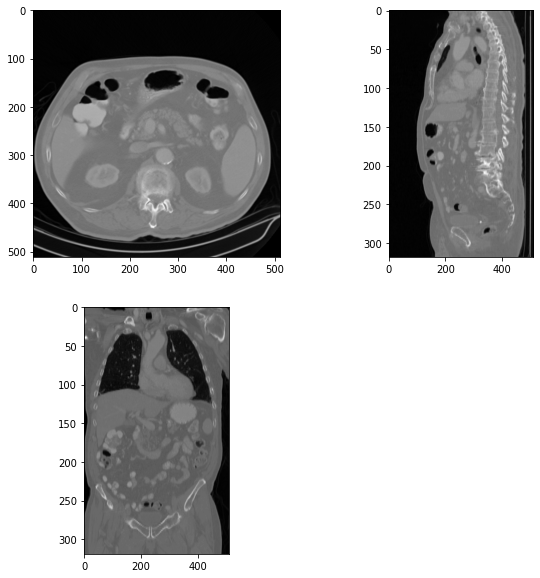

In [73]:
plot_img3d(img3d, aspects)

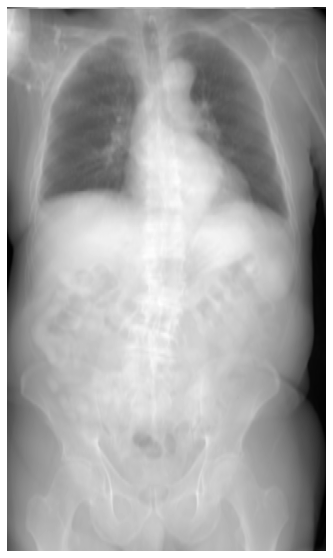

In [74]:
plot_drr(img3d, aspects)

In [409]:
mask = np.zeros(img_shape)

In [410]:
for u in filled_nodule_list:
    pos = (np.array(u['coords'])[:, 1],
    np.array(u['coords'])[:, 2],
    np.array(u['coords'])[:, 0])
    
    mask[pos] = 255
mask = mask[:, :, ::-1]

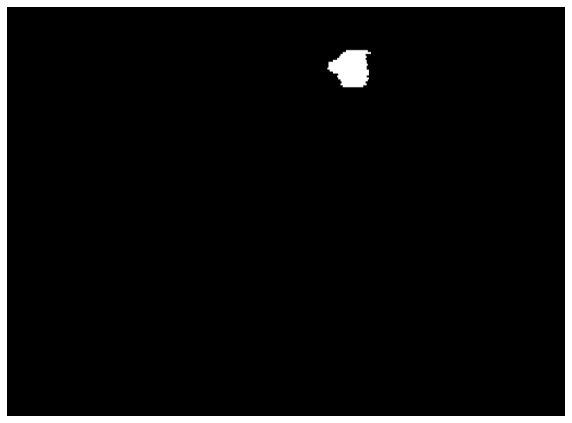

In [458]:
plot_drr(mask, aspects, mode='max')

In [518]:
a = np.where(mask == 255, np.min(img3d), img3d)

In [523]:
b = np.where(mask[:, ::-1, :] == 255, img3d[:, ::-1, :], a)

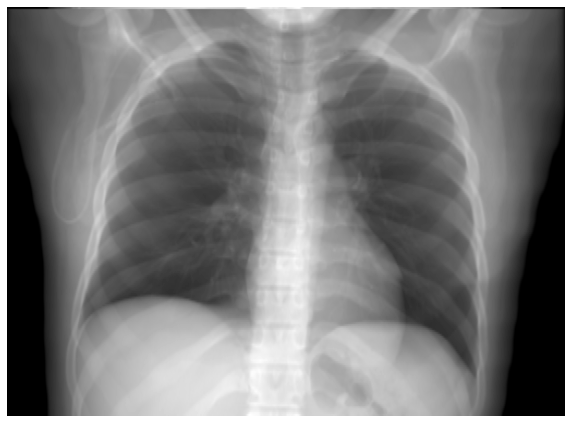

In [460]:
plot_drr(a, aspects)

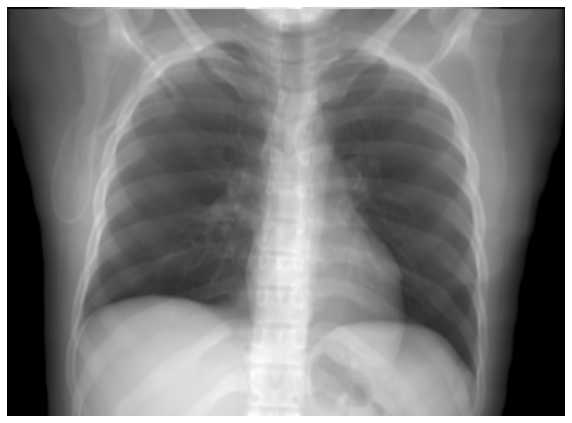

In [462]:
plot_drr(b, aspects)

In [465]:
nod_pos = np.where(mask == 255)

In [474]:
nod_pos_new = (nod_pos[0], nod_pos[1], nod_pos[2]+15)

In [502]:
nod_pos_new = (nod_pos[0], nod_pos[1]+55, nod_pos[2]+15)

In [503]:
c = a.copy()

In [504]:
c[nod_pos_new] = img3d[nod_pos]

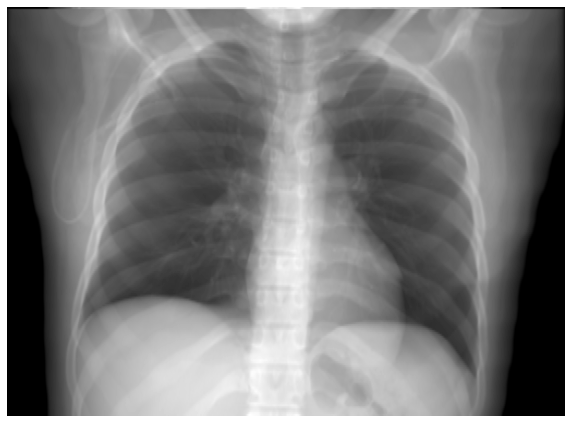

In [505]:
plot_drr(c, aspects)

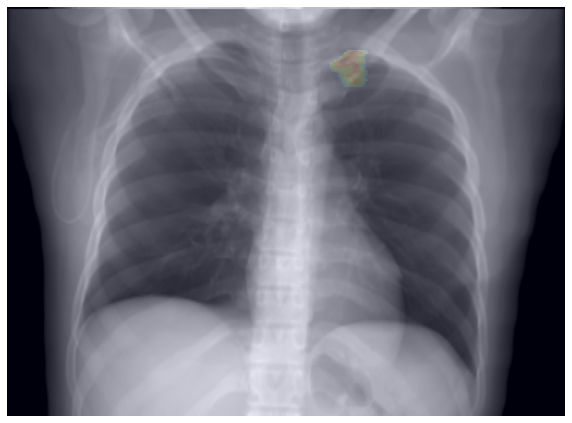

In [470]:
plot_overlay(img3d, mask, aspects, alpha=0.1)

# Lobe mask

In [441]:
mask_path = sorted(glob(f"{BASE_DIR}/stor/objects/*.nii.gz"))

In [442]:
mask_path

['LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/AirwaySeg.Obj.Airway.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LAA.Obj.Haa.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LAA.Obj.Laa.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LobeSeg.Obj.LtLower.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LobeSeg.Obj.LtUpper.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LobeSeg.Obj.RtLower.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LobeSeg.Obj.RtMiddle.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects/LobeSeg.Obj.RtUpper.nii.gz',
 'LIDC-IDRI/LIDC-IDRI-0015/01-01-2000-NA-NA-11146/3000610.000000-NA-28223/stor/objects

In [443]:
import nibabel as nib

def load_mask_dict(mask_path):
    segment_arr_dict = dict()
    mask_name = [x.split('.')[-3] for x in mask_path]
    for obj in range(len(mask_name)):
        proxy = nib.load(mask_path[obj])
        header = proxy.header
        arr = proxy.get_fdata()
        img_shape = arr.shape

        roi_img3d = np.zeros(img_shape)
        for i in range(img_shape[-1]):
            roi_img3d[:, :, i] = arr[:, :, ::-1][:, :, i].T

        segment_arr_dict[mask_name[obj]] = roi_img3d
        
    return segment_arr_dict, mask_name

In [444]:
segment_arr_dict, mask_name = load_mask_dict(mask_path)

In [445]:
mask_name

['Airway',
 'Haa',
 'Laa',
 'LtLower',
 'LtUpper',
 'RtLower',
 'RtMiddle',
 'RtUpper',
 'Airway',
 'LtLung',
 'RtLung',
 'SingleVessel']

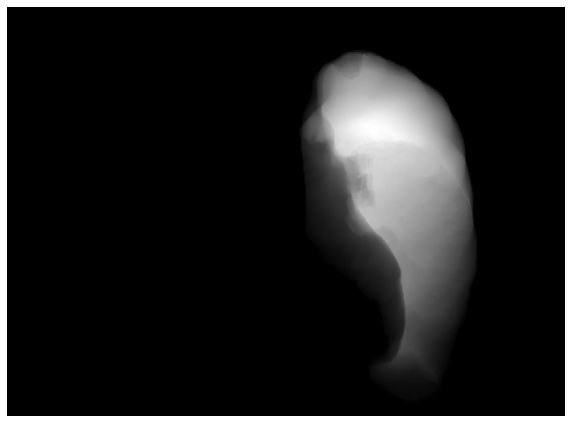

In [448]:
plot_drr(segment_arr_dict['LtUpper'], aspects)

In [576]:
img3d

(512, 512, 209)

In [10]:
nii_lst = sorted(glob("../data/NII_normwin/*_img.nii"))

In [11]:
len(nii_lst)

744